# Tea bag index (TBI) and decomposition kinetics in cranberry agroecosystems

*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [31]:
print(Sys.Date())

[1] "2020-02-27"


## Objective

This notebook generates the results included in the manuscript *Tea bag index (TBI) and decomposition kinetics in cranberry agroecosystems*. The data set from 2017 trial is a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aims of this study were to measure the TBI and kinetics of plant residue decomposition to estimate soil sequestration capacity in cranberry stands of Eastern Canada.

## Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation(Ex: [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (ex: [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). A set of other packages is used: [readxl](https://www.rdocumentation.org/packages/readxl/versions/0.1.1) for importing xlsx files, [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting a nonlinear mixed-effects model, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) for latent class analysis, [ggmap](https://www.rdocumentation.org/packages/ggmap/versions/3.0.0) for mapping, [ggrepel](https://www.rdocumentation.org/packages/ggrepel/versions/0.8.1) that provides text and label geoms for 'ggplot2' and [cowplot](https://www.rdocumentation.org/packages/cowplot/versions/1.0.0) that provides various features that help with creating publication-quality figures with 'ggplot2

In [3]:
library("tidyverse")
library("nlme")
#library("Metrics") # pour calculer le R²
library("e1071")
library("ggmap")
library("ggrepel")
library("cowplot")

Warning message:
"package 'ggrepel' was built under R version 3.6.2"

### Map design

Source : http://tile.stamen.com/terrain/10/304/360.png
Source : http://tile.stamen.com/terrain/10/305/360.png
Source : http://tile.stamen.com/terrain/10/306/360.png
Source : http://tile.stamen.com/terrain/10/307/360.png
Source : http://tile.stamen.com/terrain/10/308/360.png
Source : http://tile.stamen.com/terrain/10/309/360.png
Source : http://tile.stamen.com/terrain/10/310/360.png
Source : http://tile.stamen.com/terrain/10/304/361.png
Source : http://tile.stamen.com/terrain/10/305/361.png
Source : http://tile.stamen.com/terrain/10/306/361.png
Source : http://tile.stamen.com/terrain/10/307/361.png
Source : http://tile.stamen.com/terrain/10/308/361.png
Source : http://tile.stamen.com/terrain/10/309/361.png
Source : http://tile.stamen.com/terrain/10/310/361.png
Source : http://tile.stamen.com/terrain/10/304/362.png
Source : http://tile.stamen.com/terrain/10/305/362.png
Source : http://tile.stamen.com/terrain/10/306/362.png
Source : http://tile.stamen.com/terrain/10/307/362.png
Source : h

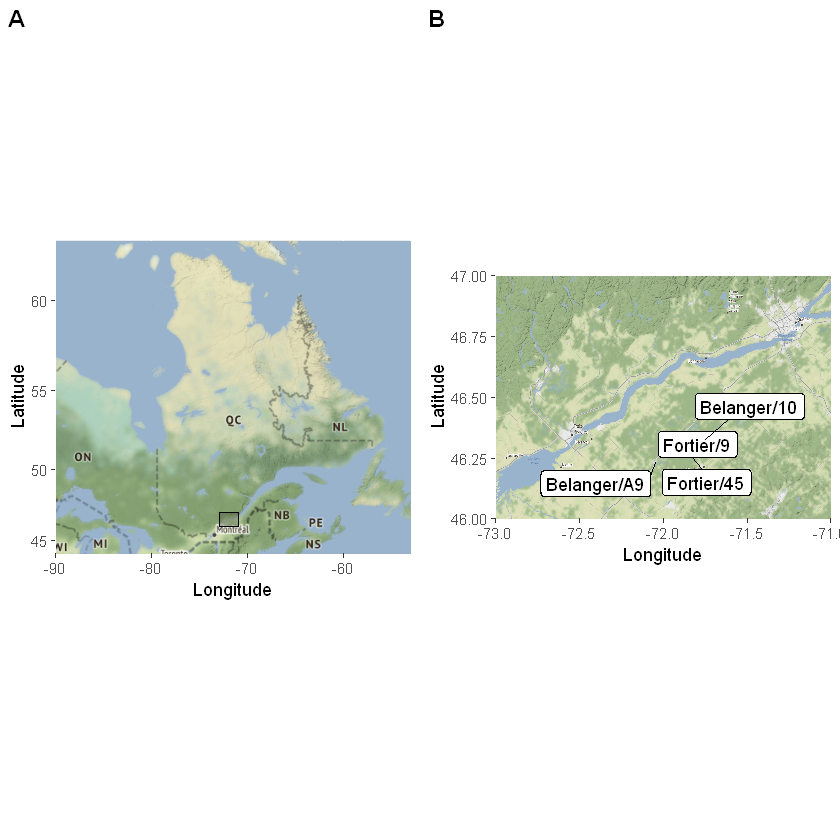

In [4]:
sites <- tibble(sites = c("", "", "", ""),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))
site <- tibble(sites = c("Fortier/45", "Fortier/9", "Belanger/A9", "Belanger/10"),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))

frame_map_zoom_out <- c(left = -90, bottom = 44, right = -53, top = 63)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -71, top = 47)

rect_zoom <- data.frame(t(data.frame(frame_map_zoom_in)))
# Zoom out
fetch_map_out <- get_map(frame_map_zoom_out, zoom = 4, source = "stamen",
                         maptype = "toner-2011")
map_out <- ggmap(fetch_map_out) +
  geom_rect(data = rect_zoom, aes(xmin = left, xmax = right,
                                  ymin = bottom, ymax = top,
                                  x = NULL, y = NULL),
            fill = rgb(0, 0, 0, 0.2), colour = "black") +
  geom_label_repel(data = sites, aes(x = lon, y = lat, label = sites)) +
  xlab("Longitude") +
  ylab("Latitude")

# Zoom in
fetch_map_in <- get_map(frame_map_zoom_in, zoom = 10, source = "stamen",
                        maptype = "toner-2011")
map_in <- ggmap(fetch_map_in) +
  geom_label_repel(data = site, aes(x = lon, y = lat, label = sites)) +
  xlab("Longitude") +
  ylab("Latitude")
plot_grid(map_out, map_in, labels = c("A", "B"))
ggsave("figures/site_map.png", width = 8, height = 6, dpi = 600)


Some custom functions.

In [33]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  library(e1071)
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}


## Import data

In [34]:
df <- read_csv("data/data__.csv")

Parsed with column specification:
cols(
  No = col_double(),
  `Tea type abbr` = col_character(),
  `Tea type` = col_character(),
  `Initial tea weight (g)` = col_double(),
  `Initial total weight (g)` = col_double(),
  `Initial bag weight (g)` = col_double(),
  `Remaining tea weight (g)` = col_double(),
  Farm = col_character(),
  Site = col_character(),
  `Farming system` = col_character(),
  `Nitrogen type` = col_character(),
  `Nitrogen dose` = col_double(),
  Repetition = col_double(),
  `Remaining C (%)` = col_double(),
  `Remaining N (%)` = col_double(),
  `Remaining S (%)` = col_double(),
  `Initial C fraction` = col_double()
)


Label repetitions in such a way they are unique per field and dose

In [35]:
df$`Dose repetition` = paste0(df$`Nitrogen dose`, '_', df$Repetition,'_', df$Site)

The *Cranberry litter* category will be used for the reference category in modeling.

In [36]:
df$`Tea type` = relevel(factor(df$`Tea type`), ref = 'Cranberry litter')

## Preprocess : weight loss rate

Weight loss rate has been estimate by

$$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$$

Where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [37]:
kinetics_1st <- function(rw, iw, t) {
    -log(rw/iw)/t
}

In [38]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## Data exploration

In [39]:
head(df)

No,Tea type abbr,Tea type,Initial tea weight (g),Initial total weight (g),Initial bag weight (g),Remaining tea weight (g),Farm,Site,Farming system,Nitrogen type,Nitrogen dose,Repetition,Remaining C (%),Remaining N (%),Remaining S (%),Initial C fraction,Dose repetition,k1
1,G,Green tea,1.793,2.019,0.226,0.783,Belanger,A9,Organic,N-8-0-0,0,1,50.144,5.2809,0.290,0.8605444,0_1_A9,0.009205698
2,G,Green tea,1.786,2.011,0.225,0.797,Belanger,A9,Organic,N-8-0-0,0,1,50.933,4.4082,0.251,0.8571847,0_1_A9,0.008965323
3,G,Green tea,1.782,2.008,0.228,NA,Belanger,A9,Organic,N-8-0-0,0,1,NA,NA,NA,0.8552650,0_1_A9,NA
4,G,Green tea,1.760,1.987,0.227,0.778,Belanger,A9,Organic,N-8-0-0,0,2,50.292,5.4397,0.296,0.8447061,0_2_A9,0.009070473
5,G,Green tea,1.788,2.013,0.226,0.779,Belanger,A9,Organic,N-8-0-0,0,2,47.718,4.8735,0.277,0.8581446,0_2_A9,0.009231577
6,G,Green tea,1.779,2.004,0.227,NA,Belanger,A9,Organic,N-8-0-0,0,2,NA,NA,NA,0.8538251,0_2_A9,NA


Boxplot

Warning message:
"Removed 49 rows containing non-finite values (stat_boxplot)."

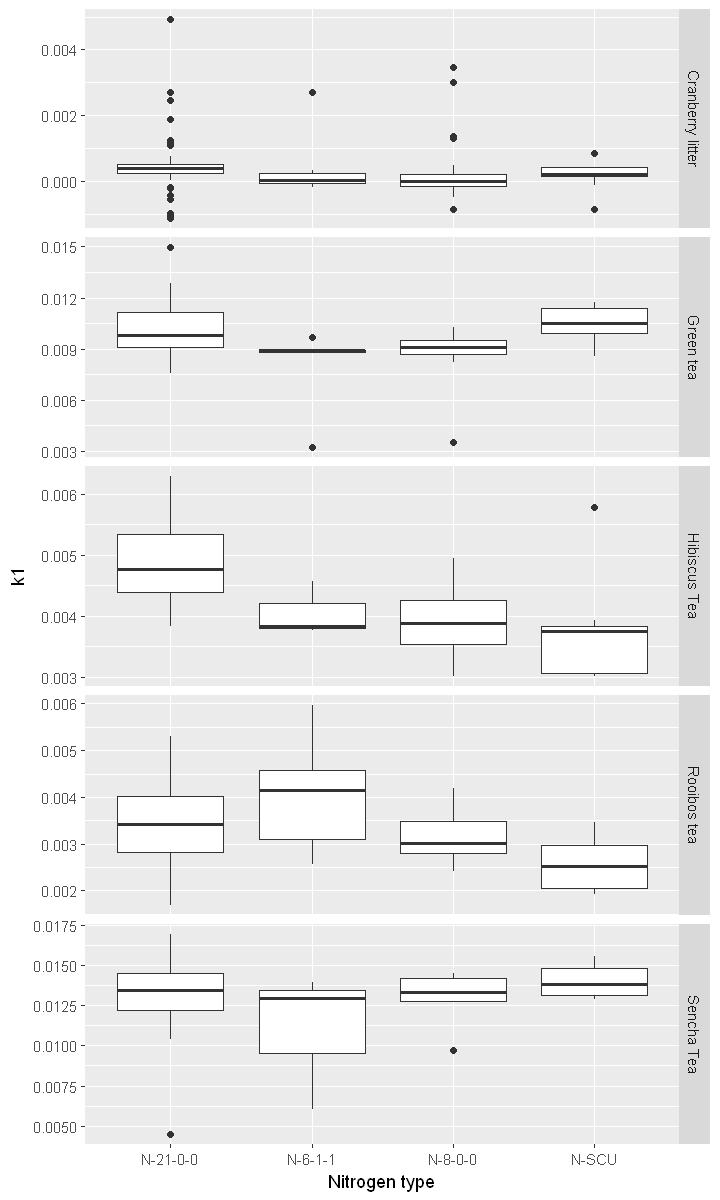

In [40]:
options(repr.plot.width=6, repr.plot.height=10)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k1)) +
  facet_grid(`Tea type` ~ ., scales = "free") +
  geom_boxplot()

## What's affecting litters weight?

### Mixed model

In [41]:
df <- df %>%
  mutate(`Nitrogen dose scaled` = scale(`Nitrogen dose`))

In [42]:
df_mm <- df %>%
  rename(tea = `Tea type`,
         Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose scaled`) %>%
  mutate(tea = factor(tea),
         Ntype = factor(Ntype)) %>%
  drop_na() %>%
  droplevels()

In [43]:
k1_mm <- lme(fixed = k1 ~ Ntype + Ndose * tea,
                     random = ~ 1 | Farm/Site,
                     data = df_mm)

In [44]:
anova(k1_mm)

,numDF,denDF,F-value,p-value
(Intercept),1,346,90.4235185,0.000000e+00
Ntype,3,346,9.2425070,6.769315e-06
Ndose,1,346,0.4951898,4.820946e-01
tea,4,346,1309.7307309,0.000000e+00
Ndose:tea,4,346,2.4427939,4.649410e-02


In [45]:
pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 0))

[1] 0.9179982

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.93463, p-value = 1.636e-11

[1] "Kurtosis: 4.72506311595992"
[1] "Skewness: 0.0203648806888307"


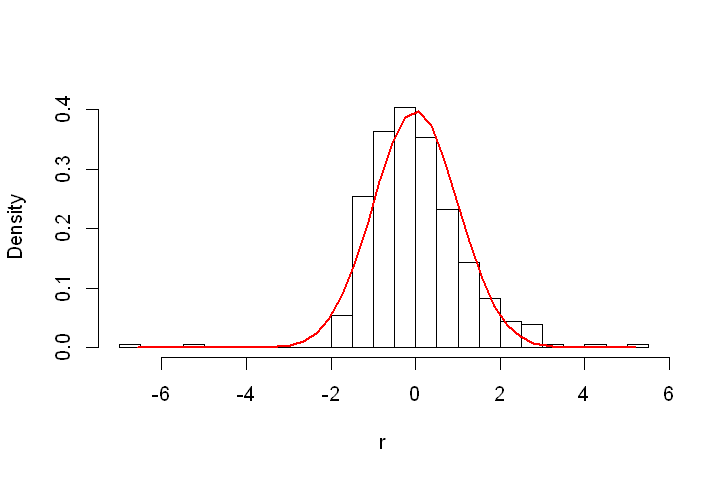

In [46]:
options(repr.plot.width=6, repr.plot.height=4)
residues(k1_mm)

In [47]:
k1_gg <- data.frame(intervals(k1_mm, which = "fixed")$fixed)
k1_gg <- k1_gg %>%
  mutate(variable = rownames(k1_gg))
k1_gg <- k1_gg %>%
  mutate(pvalue = summary(k1_mm)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [48]:
k1_gg$variable <- c("Intercept", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0",
                    "Dose N (scaled)", "Green tea", "Hibiscus tea", "Rooibos tea", "Sencha tea",
                     "Green tea : Dose N", "Hibiscus tea : Dose N", "Rooibos tea : Dose N", "Sencha tea : Dose N")

Add random effects to the table.

In [49]:
k1_re <- data.frame(matrix(ncol = ncol(k1_gg), nrow = 6))
names(k1_re) <- names(k1_gg)
k1_re$est. <- c(ranef(k1_mm)$Farm[, 1], ranef(k1_mm)$Site[, 1])
k1_re$variable <- c(rownames(ranef(k1_mm)$Farm),
                    rownames(ranef(k1_mm)$Site))

In [50]:
if (!("Belanger" %in% k1_gg$variable)) k1_gg <- bind_rows(k1_gg, k1_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [51]:
k1_gg$facet <- factor(c('Intercept',
                        'N source', 'N source', 'N source',
                        "N dosage",
                        'Tea type', 'Tea type', 'Tea type', 'Tea type',
                        'Tea type x N dosage', 'Tea type x N dosage', 
                        'Tea type x N dosage', 'Tea type x N dosage',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

In [52]:
k1_gg <- k1_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "Tea type x N dosage", "Tea type", "N dosage", "N source"))))

Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

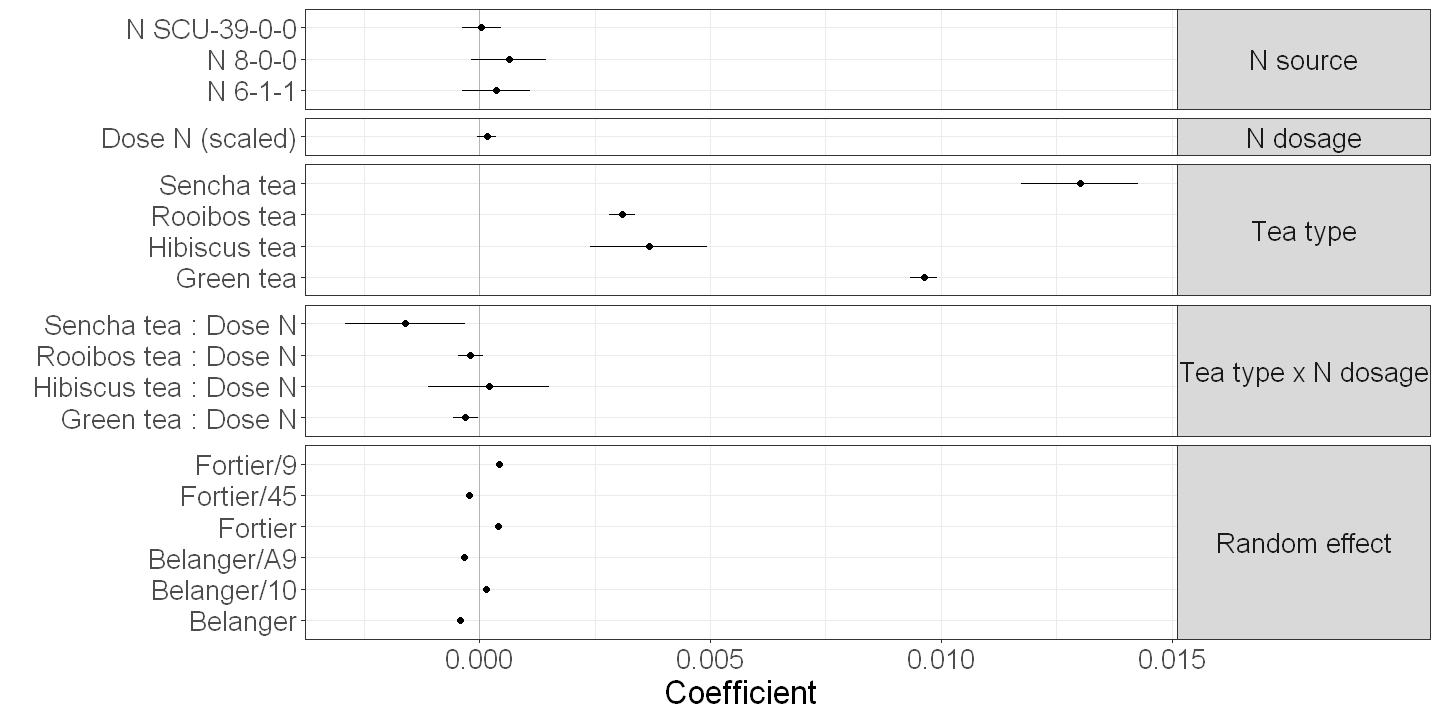

In [114]:
options(repr.plot.width=12, repr.plot.height=6)

k1_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/Figure2.png", width = 8, height = 5, dpi = 600)

In [54]:
pred_grid <- expand.grid(tea = unique(df_mm$tea),
                                     Ndose = c(-2, 2),
                                     Ntype = unique(df_mm$Ntype))
pred_grid <- pred_grid %>%
  mutate(k1 = predict(k1_mm, newdata = pred_grid,
                              level = 0),
         Ndose = Ndose * sd(df$`Nitrogen dose`) + mean(df$`Nitrogen dose`)) %>%
  rename(`Tea type` = tea,
         `Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

Warning message:
"Removed 49 rows containing missing values (geom_point)."Warning message:
"Removed 49 rows containing missing values (geom_point)."

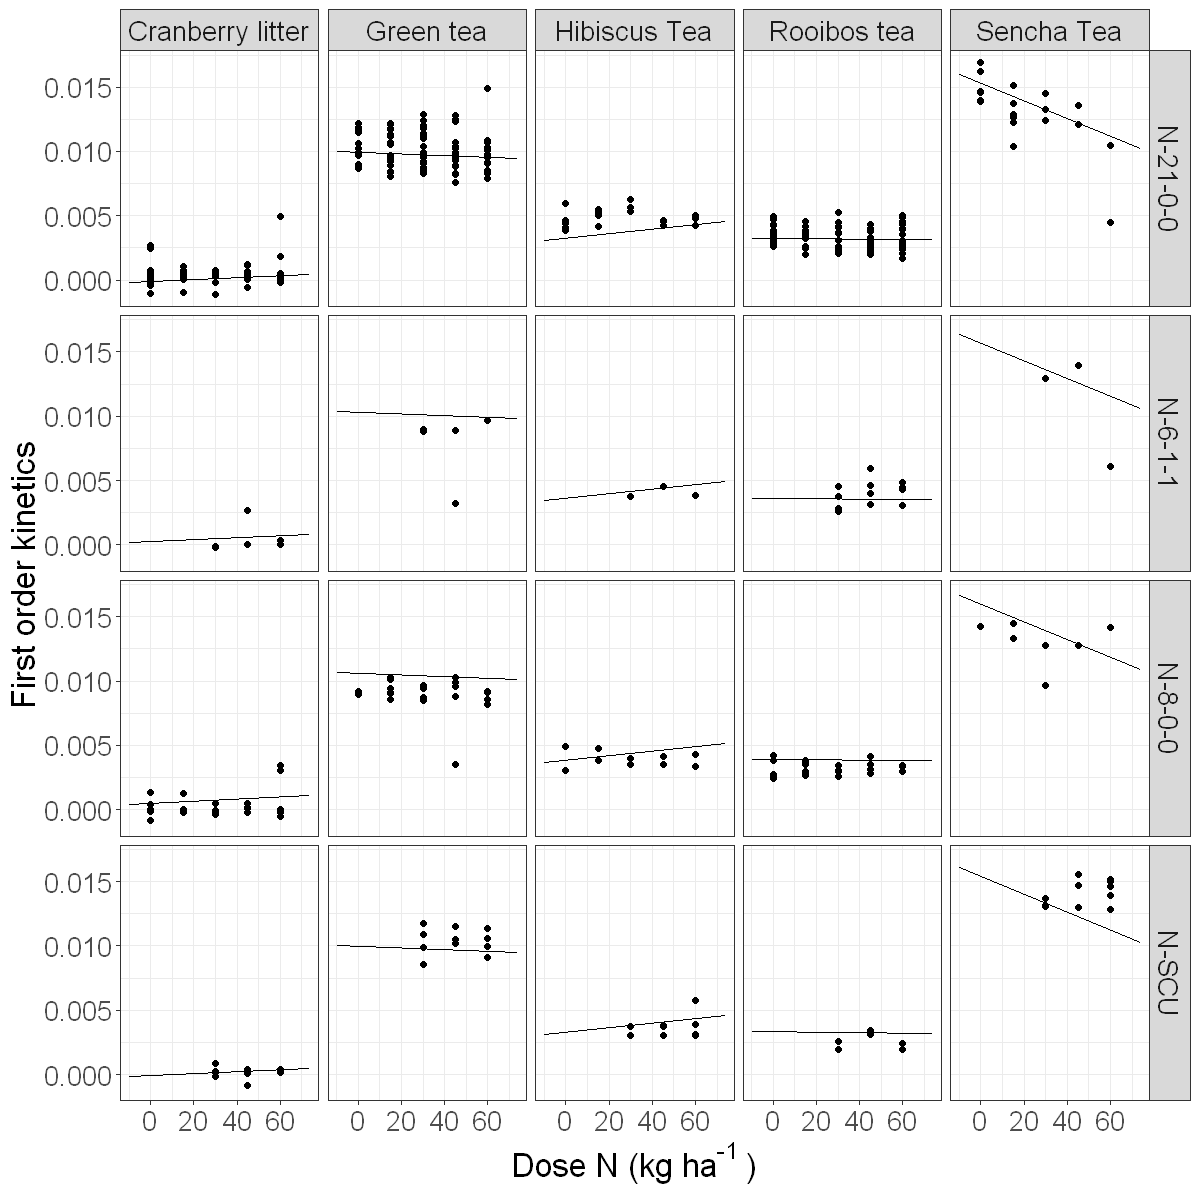

In [55]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(df, aes(x = `Nitrogen dose`, y = `k1`)) +
  facet_grid(`Nitrogen type` ~ `Tea type`) +
  geom_point() +
  geom_line(data = pred_grid) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "First order kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20)) + # strip.text.y = element_text(angle=0)
  ggsave("figures/k1-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

## Tea bag index

In [56]:
head(Data_1)

ERROR: Error in head(Data_1): objet 'Data_1' introuvable


In [57]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

Hydrolysable fraction 

In [58]:
Hf_g = 0.805 
Hf_r = 0.826

Keuskamp hydrolysable fraction

In [59]:
#Hf_g = 0.842
#Hf_r = 0.552

In [60]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

In [61]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

Compute litter stability (Green tea) and decomposition constant (Roibos) for each experimental unit.

In [62]:
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

Warning message:
"Unknown or uninitialised column: 'k_tbi'."

In [63]:
df_rooibos <- df %>%
  filter(`Tea type` == "Rooibos tea")

In [64]:
head(df_rooibos)

No,Tea type abbr,Tea type,Initial tea weight (g),Initial total weight (g),Initial bag weight (g),Remaining tea weight (g),Farm,Site,Farming system,...,Remaining S (%),Initial C fraction,Dose repetition,k1,Nitrogen dose scaled,M / M0,a,S,sdr,k_tbi
1,S,Rooibos tea,1.905,2.134,0.229,1.534,Belanger,A9,Organic,...,0.0299,0.9104313,0_1_A9,0.002406703,-1.532112,0.8052493,0.5730968,NA,A9 0 1,0.004613835
2,S,Rooibos tea,1.892,2.118,0.226,1.497,Belanger,A9,Organic,...,0.0424,0.9042183,0_1_A9,0.002601904,-1.532112,0.7912262,0.5730968,NA,A9 0 1,0.005033486
3,S,Rooibos tea,1.895,2.122,0.228,1.342,Belanger,A9,Organic,...,0.0337,0.9056521,0_1_A9,0.003833976,-1.532112,0.7081794,0.5730968,NA,A9 0 1,0.007907971
4,S,Rooibos tea,1.907,2.138,0.231,1.308,Belanger,A9,Organic,...,0.0415,0.9113871,0_2_A9,0.004189245,-1.532112,0.6858941,0.5757744,NA,A9 0 2,0.008762639
5,S,Rooibos tea,1.910,2.137,0.227,1.532,Belanger,A9,Organic,...,0.0355,0.9128208,0_2_A9,0.002450324,-1.532112,0.8020942,0.5757744,NA,A9 0 2,0.004679658
6,S,Rooibos tea,1.908,2.136,0.229,1.495,Belanger,A9,Organic,...,0.0192,0.9118650,0_2_A9,0.002710326,-1.532112,0.7835430,0.5757744,NA,A9 0 2,0.005238998


Data exploration for N dose type.

Warning message:
"Removed 388 rows containing non-finite values (stat_boxplot)."

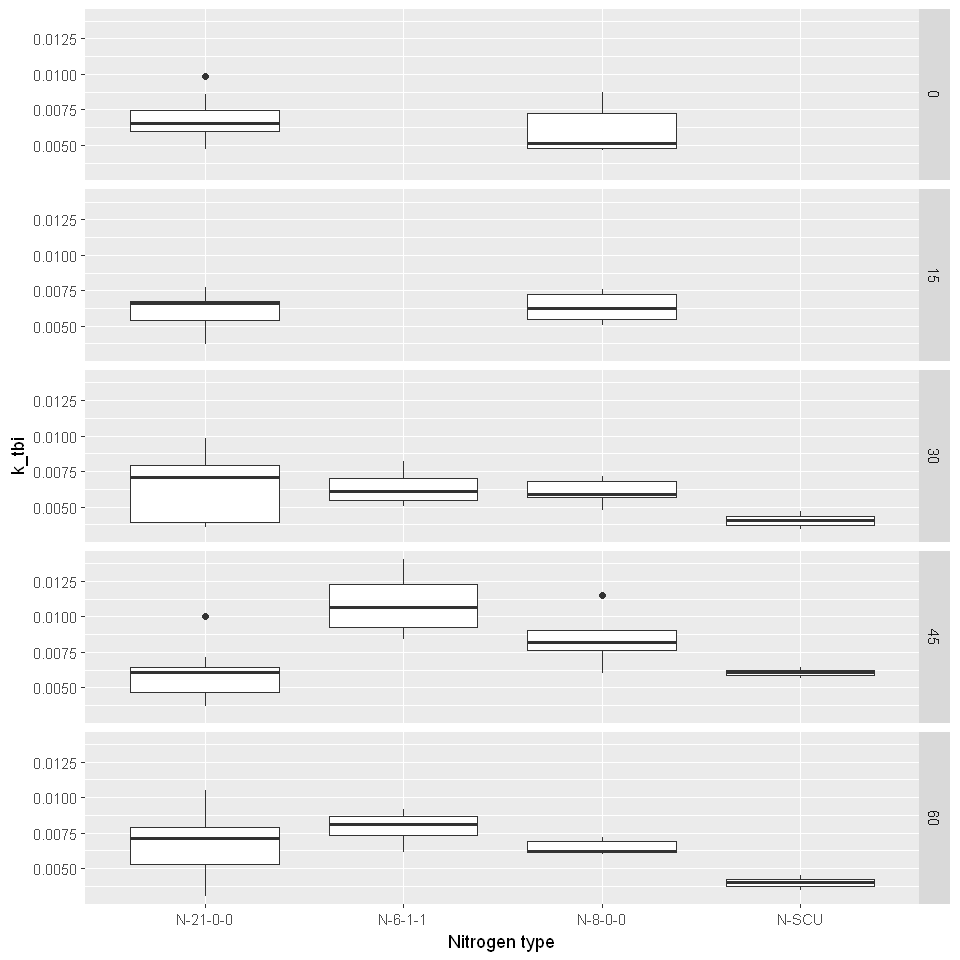

In [65]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k_tbi)) +
  facet_grid(`Nitrogen dose` ~ .) +
  geom_boxplot()

### What affecting TBI parameters (k)?

In [66]:
TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

In [67]:
TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

In [68]:
lme_TBI <- lme(fixed = k_tbi ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = TBI_rooibos) # [omdecomp_data$TauxDecomposition_C > 0, ]

In [69]:
pred_grid_tbi <- expand.grid(Ndose = c(0, 60),
                             Ntype = unique(df_mm$Ntype))
pred_grid_tbi <- pred_grid_tbi %>%
  mutate(k_tbi = predict(lme_TBI, newdata = pred_grid_tbi,
                              level = 0)) %>%
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

In [70]:
pred_grid_tbi

Nitrogen dose,Nitrogen type,k_tbi
0,N-8-0-0,0.006832646
60,N-8-0-0,0.007019623
0,N-6-1-1,0.008164878
60,N-6-1-1,0.008351855
0,N-21-0-0,0.006164356
60,N-21-0-0,0.006351333
0,N-SCU,0.005756845
60,N-SCU,0.005943822


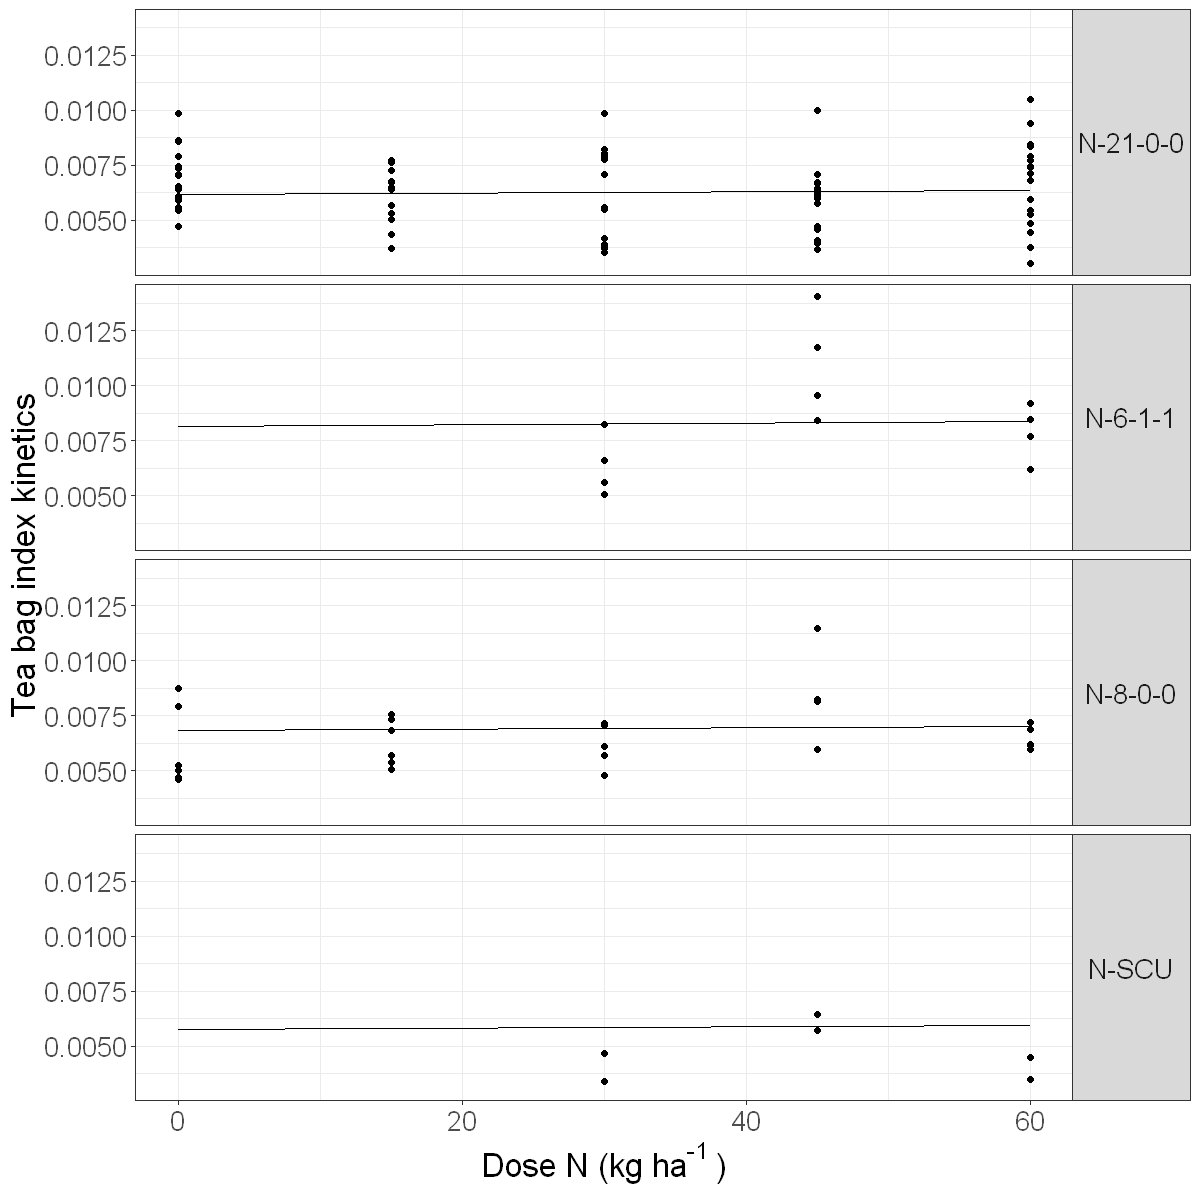

In [71]:
options(repr.plot.width=10, repr.plot.height=10)

TBI_rooibos %>% 
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype) %>%
  ggplot(aes(x = `Nitrogen dose`, y = k_tbi)) +
  facet_grid(`Nitrogen type` ~ .) +
  geom_point() +
  geom_line(data = pred_grid_tbi) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "Tea bag index kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20),
        strip.text.y = element_text(angle=0)) +
  ggsave("figures/tbi-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

In [72]:
ktbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
ktbi_gg <- ktbi_gg %>%
  mutate(variable = rownames(ktbi_gg))
ktbi_gg <- ktbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [73]:
ktbi_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

Add random effects to the table.

In [74]:
ktbi_re <- data.frame(matrix(ncol = ncol(ktbi_gg), nrow = 6))
names(ktbi_re) <- names(ktbi_gg)
ktbi_re$est. <- c(ranef(lme_TBI)$Farm[, 1], ranef(lme_TBI)$Site[, 1])
ktbi_re$variable <- c(rownames(ranef(lme_TBI)$Farm),
                    rownames(ranef(lme_TBI)$Site))

In [75]:
if (!("Belanger" %in% ktbi_gg$variable)) ktbi_gg <- bind_rows(ktbi_gg, ktbi_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [76]:
ktbi_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

In [77]:
ktbi_gg <- ktbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept"))))

Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

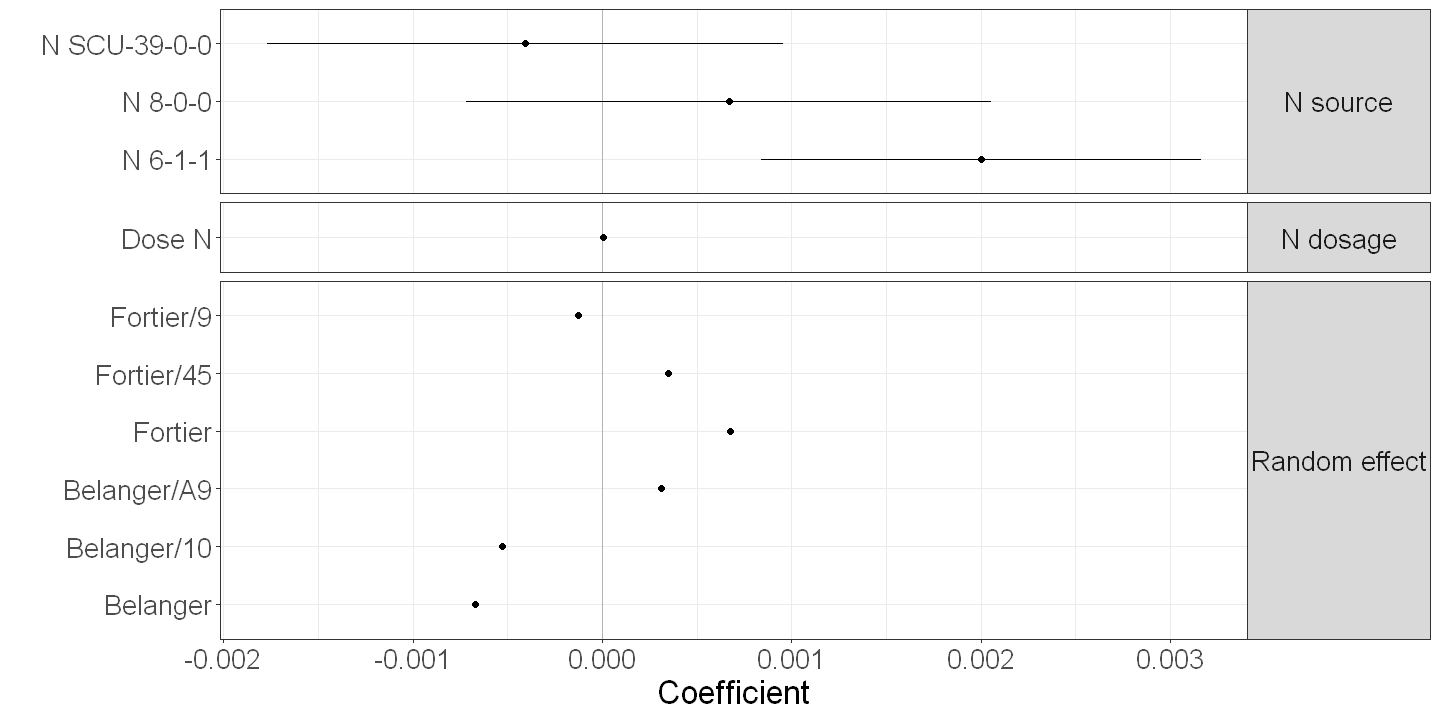

In [113]:
options(repr.plot.width=12, repr.plot.height=6)

ktbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/ktbi-lme-effects.png", width = 8, height = 5, dpi = 600)

### What affecting TBI parameters (S)?

In [79]:
S_data <- df %>%
  select(S, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

In [80]:
S_greentea <- S_data %>%
  filter(`Tea type` == "Green tea")

In [81]:
lme_S <- lme(fixed = S ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = S_greentea)

In [82]:
pred_grid_S <- expand.grid(Ndose = c(0, 60),
                           Ntype = unique(df_mm$Ntype))
pred_grid_S <- pred_grid_S %>%
  mutate(S = predict(lme_S, newdata = pred_grid_S,
                              level = 0)) %>%
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

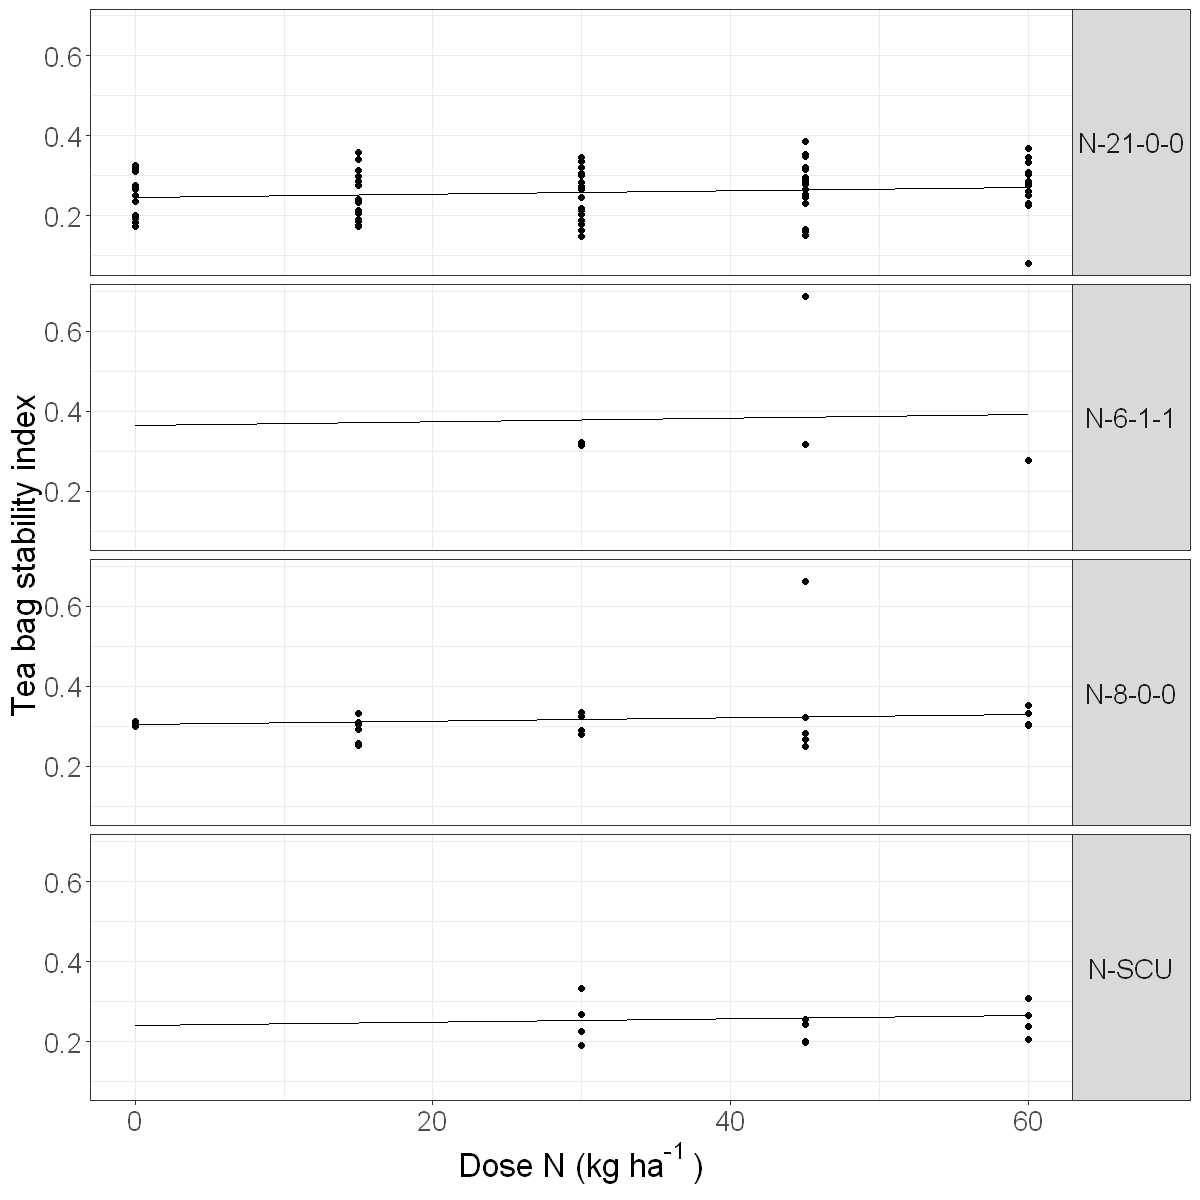

In [83]:
options(repr.plot.width=10, repr.plot.height=10)

S_greentea %>% 
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype) %>%
  ggplot(aes(x = `Nitrogen dose`, y = S)) +
  facet_grid(`Nitrogen type` ~ .) +
  geom_point() +
  geom_line(data = pred_grid_S) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "Tea bag stability index") +
  theme_bw() +
  theme(text = element_text(size = 20),
        strip.text.y = element_text(angle=0)) +
  ggsave("figures/S-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

In [84]:
S_gg <- data.frame(intervals(lme_S, which = "fixed")$fixed)
S_gg <- S_gg %>%
  mutate(variable = rownames(S_gg))
S_gg <- S_gg %>%
  mutate(pvalue = summary(lme_S)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [85]:
S_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

Add random effects to the table.

In [86]:
S_re <- data.frame(matrix(ncol = ncol(S_gg), nrow = 6))
names(S_re) <- names(S_gg)
S_re$est. <- c(ranef(lme_S)$Farm[, 1], ranef(lme_S)$Site[, 1])
S_re$variable <- c(rownames(ranef(lme_S)$Farm),
                    rownames(ranef(lme_S)$Site))

In [87]:
if (!("Belanger" %in% S_gg$variable)) S_gg <- bind_rows(S_gg, S_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [88]:
S_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

In [89]:
S_gg <- S_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept"))))

Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

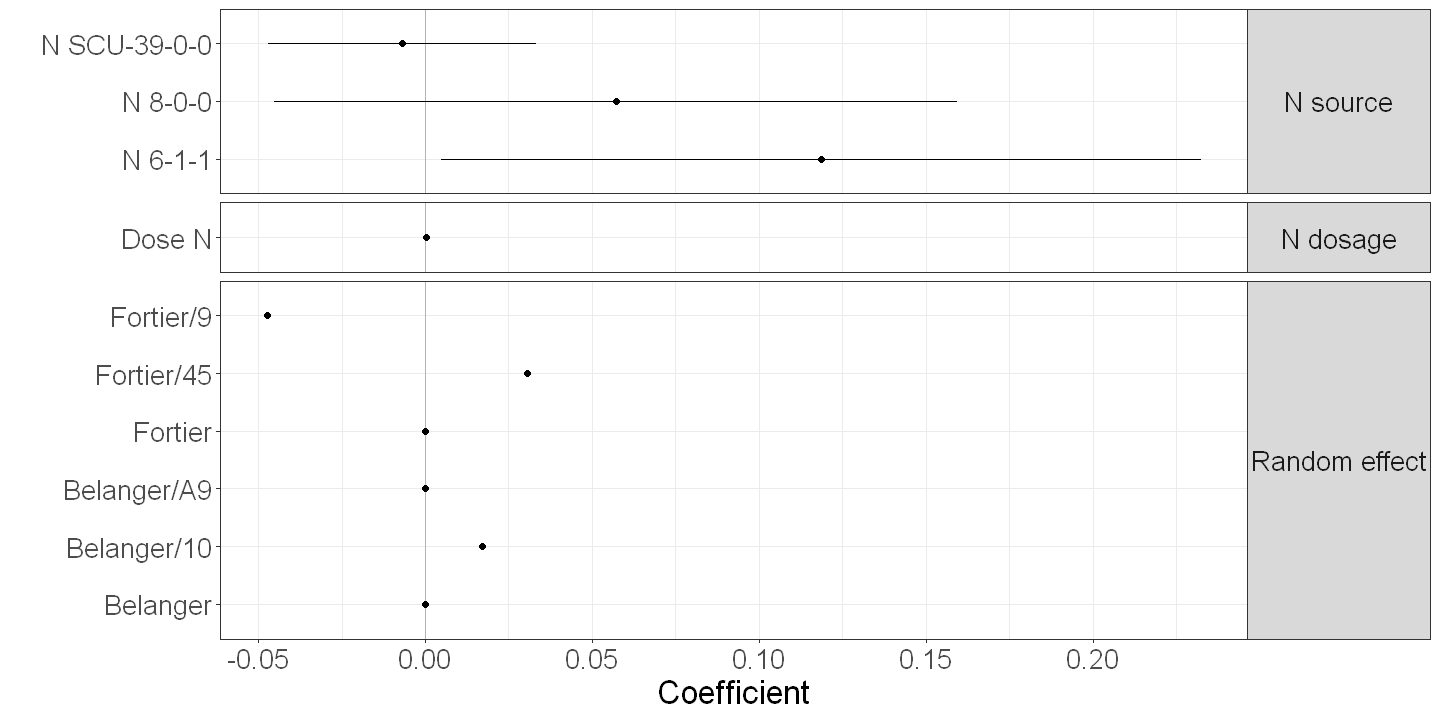

In [112]:
options(repr.plot.width=12, repr.plot.height=6)

S_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/S-lme-effects.png", width = 8, height = 5, dpi = 600)

## Reproducing Keuskamp TBI

In [100]:
library("ggrepel")
df_keuskamp <- read_csv("data/keuskamp_tbi_data.csv")

Parsed with column specification:
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  Decomposition_rate_K = col_double()
)


In [103]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries")

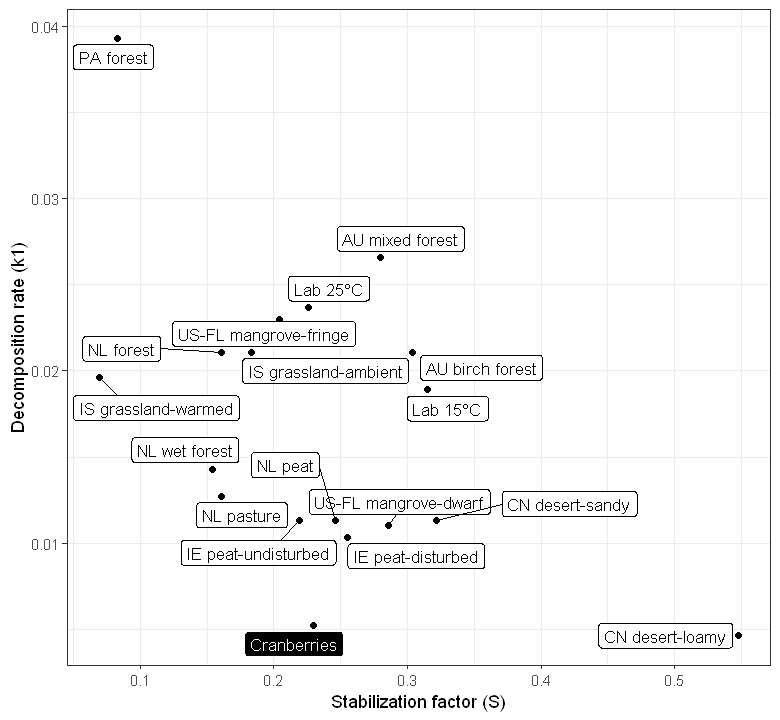

In [111]:
options(repr.plot.width=6.5, repr.plot.height=6)
ggplot(data = df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) +
  geom_point() +
  geom_label_repel(aes(label = Region, fill = is_cranberry, colour = is_cranberry),
                   size = 3.5) +
  scale_fill_manual(values = c("white", "black")) +
  scale_colour_manual(values = c("black", "white")) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Stabilization factor (S)", y = "Decomposition rate (k1)") +
  ggsave("figures/TBI_keuskamp.png", width = 6, height = 6, dpi = 120)